# [DeepSphere]: a spherical convolutional neural network
[DeepSphere]: https://github.com/SwissDataScienceCenter/DeepSphere

[Nathanaël Perraudin](https://perraudin.info), [Michaël Defferrard](http://deff.ch), Tomasz Kacprzak, Raphael Sgier

# Demo: part of sphere classification

This demo uses the whole datataset, smoothing, and the addition of noise.

**You need a private dataset to execute this notebook.**
See the [README](https://github.com/SwissDataScienceCenter/DeepSphere/tree/master#reproducing-the-results-of-the-paper).
But you can use it with your own data.

### 0.1 Load packages

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import shutil

# Run on first GPU.
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

# To get the CUDA profiler (do it on the CLI before starting jupyter):
# export LD_LIBRARY_PATH=/usr/local/cuda-9.0/extras/CUPTI/lib64

import numpy as np
import matplotlib.pyplot as plt

from deepsphere import models, experiment_helper, plot, utils
from deepsphere.data import LabeledDatasetWithNoise, LabeledDataset
import hyperparameters

In [3]:
plt.rcParams['figure.figsize'] = (17, 5)

### 0.2 Definition of the parameters

#### A) Non tunable parameters
These parameters are fixed or the preprocessing script has to be modified.

In [4]:
Nside = 1024
sigma = 3
data_path = '../../../lts2/mdeff/share-michael-nati/data/same_psd/'

#### B) Tunable parameters
These parameters can be changed.

We choose to work in the noiseless setting by setting `sigma_noise = 0`. This allows this notebook to run an acceptable time. In the noisy case, the training of the network needs considerably more iterations.

In [5]:
order = 2  # 1,2,4,8 correspond to 12,48,192,768 parts of the sphere.
sigma_noise = 2  # Amount of noise for the experiment

# 1 Data preparation

### 1.1 Data download
Set `download` to `True` to download the dataset from zenodo

In [6]:
download = False
if download:
    %run -i 'download.py'

### 1.2 Data preprocessing
Apply the preprocessing steps.
1. Remove the mean of the maps
2. Smooth with a radius of 3 arcmin. (`sigma` parameter)

Set `preprocess` to `True` to execute the preprocessing script.

In [7]:
preprocess = False
if preprocess:
    %run -i 'data_preprocess.py'

Let us display the resulting PSDs of the preprocessed data. We pre-computed the PSDs for faster execution.

In [8]:
compute = False
if compute:
    psd = experiment_helper.psd
    data_path = 'data/same_psd/'
    ds1 = np.load(data_path+'smoothed_class1_sigma{}.npz'.format(sigma))['arr_0']
    ds2 = np.load(data_path+'smoothed_class2_sigma{}.npz'.format(sigma))['arr_0']
    psds_img1 = [psd(img) for img in ds1]
    psds_img2 = [psd(img) for img in ds2]
    np.savez('results/psd_data_sigma{}'.format(sigma), psd_class1=psds_img1, psd_class2=psds_img2)
else:
    psds_img1 = np.load('results/psd_data_sigma{}.npz'.format(sigma))['psd_class1']
    psds_img2 = np.load('results/psd_data_sigma{}.npz'.format(sigma))['psd_class2']

The PSD of the two classes is almost indistinguishable. 

Spoiler Alert! This is the reason why PSD features are not good enough to classify the data.

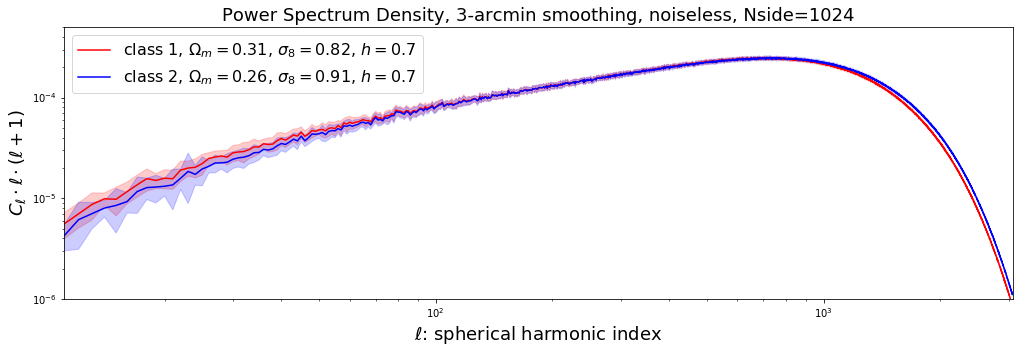

In [9]:
ell = np.arange(psds_img1.shape[1])

plot.plot_with_std(ell,np.stack(psds_img1)*ell*(ell+1), label='class 1, $\Omega_m=0.31$, $\sigma_8=0.82$, $h=0.7$', color='r')
plot.plot_with_std(ell,np.stack(psds_img2)*ell*(ell+1), label='class 2, $\Omega_m=0.26$, $\sigma_8=0.91$, $h=0.7$', color='b')
plt.legend(fontsize=16);
plt.xlim([11, np.max(ell)])
plt.ylim([1e-6, 5e-4])
plt.yscale('log')
plt.xscale('log')
plt.xlabel('$\ell$: spherical harmonic index', fontsize=18)
plt.ylabel('$C_\ell \cdot \ell \cdot (\ell+1)$', fontsize=18)
plt.title('Power Spectrum Density, 3-arcmin smoothing, noiseless, Nside=1024', fontsize=18);


### 1.2 Data loading
The following functions will
1. Load the preprocessed data
2. Create samples by dividing the complete spheres in patches (based on healpix sampling). See the function `hp_split` of `experiment_helper.py` for more specific informations.

The function that load the testing data will additionally add the noise to the sample.

In [10]:
x_raw_train, labels_raw_train, x_raw_std = experiment_helper.get_training_data(sigma, order, data_path)

In [11]:
x_raw_test, labels_test, _ = experiment_helper.get_testing_data(sigma, order, sigma_noise, x_raw_std, data_path[:-9])

# 2 Solve the problem using histogram features and an SVM classifier

### 2.1 Features compuation and dataset creation
The following function prepare the features for the SVM classifier.
1. It splits the training data into a training and a validation set.
2. It augments the training set by adding different realization of random noise to the sample
3. It computes the histogram features for the training, validation and testing set.
4. It normalizes the features in order for them to have a mean of 0 and a variance of 1.

The features are computed using the function `histogram` of `experiment_helper.py`.

We use 10 different noise realization by setting `augmentation=10` in order to increase the number of training sample.

In [ ]:
ret = experiment_helper.data_preprossing(x_raw_train, labels_raw_train, x_raw_test, sigma_noise, feature_type='histogram', augmentation=10)
features_train, labels_train, features_validation, labels_validation, features_test = ret 

### 2.2  Classification using SVM
Let us test classify our data using an SVM classifier.

In [ ]:
error_train, error_validation, C = experiment_helper.err_svc_linear(features_train, labels_train, features_validation, labels_validation)


In [ ]:
print('The validation error is {}%'.format(error_validation * 100), flush=True)
print('The Training error is {}%'.format(error_train * 100), flush=True)


We now compute the error on the testing set. To avoid complexity, we do a small mistake that advantage the SVM classifer: we do cross-validation on the testing set.

While this is wrong, the spherical CNN still clearly outperform the SVM classifier.

In [ ]:
_, error_test = experiment_helper.err_svc_linear_single(C, features_train, labels_train, features_test, labels_test)

In [ ]:
print('The testing error is {}%'.format(error_test * 100), flush=True)

### 2.3 Histogram features visualization

To get a grasp of what is happening, let us plot the histogram of the data.

In [ ]:
cmin = np.min(x_raw_train)
cmax = np.max(x_raw_train)
bins = 100
x = np.linspace(cmin,cmax,bins)

fig, axes = plt.subplots(1, 2)
x_hist = experiment_helper.histogram(x_raw_train, cmin, cmax)
plot.plot_with_std(x, x_hist[labels_raw_train==0], color='b', label='class 1', ax=axes[0])
plot.plot_with_std(x, x_hist[labels_raw_train==1], color='r', label='class 2', ax=axes[0])
axes[0].legend()
axes[0].set_title('Histogram - Noiselss case');

if sigma_noise:
    # Updating cmin and cmax does not really affect the features. 
    # We keep the same as in the noisless case in order to have the same x axis.
    x_hist = experiment_helper.histogram(x_raw_train+sigma_noise*np.random.randn(*x_raw_train.shape), cmin, cmax)
    plot.plot_with_std(x, x_hist[labels_raw_train==0], color='b', label='class 1', ax=axes[1])
    plot.plot_with_std(x, x_hist[labels_raw_train==1], color='r', label='class 2', ax=axes[1])
    axes[1].legend()
    axes[1].set_title('Histogram-  Noisy case');


These histogram are normalized in order to get the final features

In [ ]:
ax = plot.plot_with_std(features_train[labels_train==0], color='b', label='class 1')
ax = plot.plot_with_std(features_train[labels_train==1], color='r', label='class 2', ax=ax)
ax.legend()
ax.set_title('Histogram features');

In [ ]:
# ax = plot.plot_with_std(features_validation[labels_validation==0,:80], color='b', label='class 1')
# ax = plot.plot_with_std(features_validation[labels_validation==1,:80], color='r', label='class 2', ax=ax)
# ax.legend()
# ax.set_title('Histogram features - Validation set');

In [ ]:
# ax = plot.plot_with_std(features_test[labels_test==0,:80], color='b', label='class 1')
# ax = plot.plot_with_std(features_test[labels_test==1,:80], color='r', label='class 2', ax=ax)
# ax.legend()
# ax.set_title('Histogram features - Test set');

# 3 Solve the problem using PSD features and an SVM classifier
Solving the problem with PSD features is very similar than solving it with histogram features. Hence we are not describing each step.

The computation of the PSD features is actually very expensive. Since the classifier will also fail miserably, you may just want to not exectute this part of the notebook. In order to reduce the amount of PSD to be computed, we disable the dataset augementation by setting `augmentation=1`. Nevertheless, we use augmentation for the results in the paper.

In [ ]:
ret = experiment_helper.data_preprossing(x_raw_train, labels_raw_train, x_raw_test, sigma_noise, feature_type='psd', augmentation=1)
features_train, labels_train, features_validation, labels_validation, features_test = ret 

In [ ]:
error_train, error_validation, C = experiment_helper.err_svc_linear(features_train, labels_train, features_validation, labels_validation)
print('The validation error is {}%'.format(error_validation * 100), flush=True)
print('The Training error is {}%'.format(error_train * 100), flush=True)

In [ ]:
_, error_test = experiment_helper.err_svc_linear_single(C, features_train, labels_train, features_test, labels_test)
print('The testing error is {}%'.format(error_test * 100), flush=True)

### 2.3 PSD features visualization

To get a grasp of what is happening, let us plot the psd features. 

In [ ]:
ell = np.arange(features_train.shape[1])
ax = plot.plot_with_std(ell, features_train[labels_train==0], color='b', label='class 1')
ax = plot.plot_with_std(ell, features_train[labels_train==1], color='r', label='class 2', ax=ax)
ax.legend()
ax.set_title('PSD features');
# plt.xscale('log')

In [ ]:
# ell = np.arange(features_train.shape[1])
# ax = plot.plot_with_std(ell, features_validation[labels_validation==0], color='b', label='class 1')
# ax = plot.plot_with_std(ell, features_validation[labels_validation==1], color='r', label='class 2', ax=ax)
# ax.legend()
# ax.set_title('PSD features - validation dataset');
# # plt.xscale('log')

In [ ]:
# ell = np.arange(features_train.shape[1])
# ax = plot.plot_with_std(ell, features_test[labels_test==0], color='b', label='class 1')
# ax = plot.plot_with_std(ell, features_test[labels_test==1], color='r', label='class 2', ax=ax)
# ax.legend()
# ax.set_title('PSD features - testing dataset');
# # plt.xscale('log')

# 4 Classification using Deep Sphere

Let us now classify our data using a spherical convolutional neural network.

### 4.1 Preparation of the dataset
Let us create the datafor the spherical neural network. It is simply the raw data.

In [12]:
ret = experiment_helper.data_preprossing(x_raw_train, labels_raw_train, x_raw_test, sigma_noise, feature_type=None, train_size=0.8)
features_train, labels_train, features_validation, labels_validation, features_test = ret

Class 1 VS class 2
  Training set: 765 / 771
  Validation set: 195 / 189


The spherical neural network will uses a Dataset object that need to be initialized. The object `LabeledDatasetWithNoise` will add noise to the raw data at the time of training. It will slowly increase the amount of noise during `nit` iteration.

In [13]:
training = LabeledDatasetWithNoise(features_train, labels_train, end_level=sigma_noise)
validation = LabeledDataset(features_validation, labels_validation)

### 4.2 Building the Network

We now create our spherical neural network. We use one architecture, a fully convolutional architecture (see the exact parameters in `hyperparameters.py`), for all the problems (that is for all configurations of `order` and `sigma_noise`. A smaller `order` means more pixels per sample, that is more data for a prediction. It translates to higher accuracy as the network is more confident about its prediction (as they are averaged across spatial locations).

For the paper, we selected a conservative set of parameters that were providing good results across the board. To train faster, diminish `num_epochs`, or interrupt training whenever you get bored. To reproduce all the results from the paper, the easiest is to run the `experiments_deepsphere.py` script.

In [14]:
ntype = 'FCN'
EXP_NAME = '40sim_{}sides_{:0.1f}noise_{}order_{}sigma_{}'.format(Nside, sigma_noise, order, sigma, ntype)

In [21]:
params = hyperparameters.get_params(training.N, EXP_NAME, order, Nside, ntype)
#params['profile'] = True  # See computation time and memory usage in Tensorboard.
#params['debug'] = True  # Debug the model in Tensorboard.
model = models.deepsphere(**params)

#sides: [1024, 512, 256, 128, 64, 32, 32]
#pixels: [262144, 65536, 16384, 4096, 1024, 256, 256]
#samples per batch: 64
=> #pixels per batch (input): 16,777,216
=> #pixels for training (input): 32,212,254,720
Learning rate will start at 2.0e-04 and finish at 2.9e-05.
NN architecture
  input: M_0 = 262144
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 262144 * 16 / 4 = 1048576
    weights: F_0 * F_1 * K_1 = 1 * 16 * 5 = 80
    biases: F_1 = 16
    batch normalization
  layer 2: cgconv2
    representation: M_1 * F_2 / p_2 = 65536 * 32 / 4 = 524288
    weights: F_1 * F_2 * K_2 = 16 * 32 * 5 = 2560
    biases: F_2 = 32
    batch normalization
  layer 3: cgconv3
    representation: M_2 * F_3 / p_3 = 16384 * 64 / 4 = 262144
    weights: F_2 * F_3 * K_3 = 32 * 64 * 5 = 10240
    biases: F_3 = 64
    batch normalization
  layer 4: cgconv4
    representation: M_3 * F_4 / p_4 = 4096 * 64 / 4 = 65536
    weights: F_3 * F_4 * K_4 = 64 * 64 * 5 = 20480
    biases: F_4 = 64
    batch normal

In [16]:
# Cleanup before running again.
shutil.rmtree('summaries/{}/'.format(EXP_NAME), ignore_errors=True)
shutil.rmtree('checkpoints/{}/'.format(EXP_NAME), ignore_errors=True)

### 4.3 Find an optimal learning rate (optional)

The learning rate is the most important hyper-parameter. A technique to find an optimal value is to visualize the validation loss while increasing the learning rate. One way to define the optimal learning rate is to search for the largest value looking for which the validation loss still decreases.

In [17]:
# backup = params.copy()
# 
# params, learning_rate = utils.test_learning_rates(params, training.N, 1e-6, 1e-1, num_epochs=20)
# 
# shutil.rmtree('summaries/{}/'.format(params['dir_name']), ignore_errors=True)
# shutil.rmtree('checkpoints/{}/'.format(params['dir_name']), ignore_errors=True)
# 
# model = models.deepsphere(**params)
# _, loss_validation, _, _ = model.fit(training, validation)
# 
# params.update(backup)
#
# plt.semilogx(learning_rate, loss_validation, '.-')

### 4.4 Training the network

Here are a few remarks.
* The model will create tensorboard summaries in the `summaries` folder. Start tensorboard with `cd summaries` then `tensorboard --logdir .`, and open <http://localhost:6006> in a browser tab to visualize training progress and statistics about the learned parameters. You can debug the model by setting `params['debug'] = True` and launching tensorboard with `tensorboard --logdir . --debugger_port 6064`.
* You probably need a GPU to train the model in an acceptable amount of time.
* You will get slightly different results every time the network is trained.

In [ ]:
accuracy_validation, loss_validation, loss_training, t_step = model.fit(training, validation)

step 9 / 1920 (epoch 0.38 / 80):
  learning_rate = 1.97e-04, training loss = 6.72e-01
set()
  validation accuracy: 49.22 (189 / 384), f1 (weighted): 32.47, loss: 1.13e+00
  CPU time: 32s, wall time: 55s


/home/gusset/miniconda3/envs/PDMsphere/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


step 18 / 1920 (epoch 0.75 / 80):
  learning_rate = 1.93e-04, training loss = 6.62e-01
set()
  validation accuracy: 49.22 (189 / 384), f1 (weighted): 32.47, loss: 1.36e+00
  CPU time: 59s, wall time: 107s


We can see below that the classifier does not overfit the training data.

In [ ]:
plot.plot_loss(loss_training, loss_validation, t_step, params['eval_frequency'])

In [ ]:
error_validation = experiment_helper.model_error(model, features_validation, labels_validation)
print('The validation error is {:.2%}'.format(error_validation), flush=True)

In [ ]:
error_test = experiment_helper.model_error(model, features_test, labels_test)
print('The testing error is {:.2%}'.format(error_test), flush=True)

## 5 Filters visualization

The package offers a few different visualizations for the learned filters. First we can simply look at the Chebyshef coefficients. This visualization is not very interpretable for human, but can help for debugging problems related to optimization.

In [ ]:
layer=2
ind_in = range(6) # Should be None if layer=1
ind_out = range(4)
model.plot_chebyshev_coeffs(layer, ind_in, ind_out)

We observe the Chebyshef polynomials, i.e the filters in the graph spectral domain. This visuallization can help to understand wich graph frequencies are picked by the filtering operation. It mostly interpretable by the people for the graph signal processing community.

In [ ]:
model.plot_filters_spectral(layer, ind_in, ind_out);

Here comes one of the most human friendly representation of the filters. It consists the section of the filters "projected" on the sphere. Because of the irregularity of the healpix sampling, this representation of the filters may not look very smooth.

In [ ]:
import matplotlib
matplotlib.rcParams.update({'font.size': 16})
model.plot_filters_section(layer, ind_in, ind_out, title='');

Eventually, we can simply look at the filters on sphere. This representation clearly displays the sampling artifacts.

In [ ]:
plt.rcParams['figure.figsize'] = (10, 17)
model.plot_filters_gnomonic(layer, ind_in, ind_out, title='');